## Notebook de prueba para experimentar con Bluetooth

In [1]:
import socket
import asyncio

import time
from time import sleep
from IPython.display import clear_output

import pandas as pd
import os

___
<font size="5px">[Usar módulo personalizado](#PulseOximeterBLE)</font>
___

### Adafruit

In [3]:
import adafruit_ble
from adafruit_ble import BLERadio

In [3]:
# radio = BLERadio()
# print("Scanning...")
# found = set()
# for entry in radio.start_scan(timeout=60, minimum_rssi=-80):
#     addr = entry.address
#     if addr not in found:
#         print(entry)
#     found.add(addr)
# found

In [4]:
addr = "FB:2F:07:A1:F7:A3"

In [5]:
import _bleio
import adafruit_ble

from adafruit_ble.advertising.standard import Advertisement
from adafruit_ble.services.standard.device_info import DeviceInfoService
from adafruit_ble_berrymed_pulse_oximeter import BerryMedPulseOximeterService

connection_error = ConnectionError
if hasattr(_bleio, "ConnectionError"):
    connection_error = _bleio.ConnectionError

In [6]:
# ble = adafruit_ble.BLERadio()
# pulse_ox_connection = None

### Establecer conexión con el dispositivo

In [34]:
def connect_BLE(target_name="BerryMed", timeout=15):
    
    print("Buscando dispositivos Bluetooth...")
    print("Objetivo:", target_name)
    
    found = set()
    
    # Radio para escanear dispositivos
    ble = adafruit_ble.BLERadio()
    
    # Variable para la conexion
    global pulse_ox_connection
    pulse_ox_connection = None
    
    for adv in ble.start_scan(Advertisement, timeout=timeout):
        name = adv.complete_name
        print(adv)
        if not name:
            continue

#         name = name.strip("\x00")

        # "BerryMed" devices may have trailing nulls on their name.
        if name == target_name:
            print("\nEstableciendo conexión con", name,"...")
            pulse_ox_connection = ble.connect(adv)
            break

        elif name not in found:
            print("Encontrado:", name, "(X)")
            found.add(name)

    # Stop scanning whether or not we are connected.
    ble.stop_scan()
    
    if pulse_ox_connection and pulse_ox_connection.connected:
        print("=> Dispositivo conectado.")
    
    else:
        print(f"No se ha encontrado el dispositivo '{target_name}'. Deteniendo escaneo.")

## Recibir datos del dispositivo

In [27]:
def receive_data():  

    if pulse_ox_connection and pulse_ox_connection.connected:
        print("\nLeyendo dispositivo...")
        
        # Información del dispositivo
        if DeviceInfoService in pulse_ox_connection:
            dis = pulse_ox_connection[DeviceInfoService]
            
            # Manufacturer
            try: manufacturer = dis.manufacturer
            except AttributeError: manufacturer = "(Manufacturer Not specified)"
            
            # Model Number
            try: model_number = dis.model_number
            except AttributeError: model_number = "(Model number not specified)"
                
            print("Device:", manufacturer, model_number, '\n')
            
        else:
            print("Sin información del dispositivo.\n")
        
    # -- Extracción de datos -- #
        pulse_ox_service = pulse_ox_connection[BerryMedPulseOximeterService]
        
        # Listas de datos
        BPM_list  = list()
        SpO2_list = list()

        timestamps = list()
        
        global data_full
        data_full = list()
    
        print("--- Lectura comenzada ---\n")
        
        t0 = time.perf_counter()
        
        # Lectura continua
        while pulse_ox_connection.connected:
            data = pulse_ox_service.values
            
            # Datos extraídos
            if data:
                [valid, SpO2, BPM, pleth, finger_inside] = data
                
                valid = valid and finger_inside and BPM < 255
            
                if valid:
                    t = round(time.perf_counter() - t0, 3)
                    timestamps.append(t)
                    
                    print(f"Pulso: {BPM}, SpO2: {SpO2}")
                    
                    BPM_list.append(BPM)
                    SpO2_list.append(SpO2)

                    data_full.append(data)
            
        print("\n--- Lectura finalizada ---")
        
        global BPM_series;
        global SpO2_series; 
        
        BPM_series  = pd.Series(BPM_list,  index=timestamps)
        SpO2_series = pd.Series(SpO2_list, index=timestamps)
        
        recorded_data = pd.DataFrame()
        
    print("=> Dispositivo desconectado.")

### Error de conexión

In [12]:
def connection_pulse_ox_error():
    try:
        pulse_ox_connection.disconnect()
    except connection_error:
        pass
    pulse_ox_connection = None
    
    return pulse_ox_connection

## Bloque principal

In [16]:
# sleep(30)
connect_BLE("BerryMed", 15)

try:
    receive_data()
    
except connection_error:
    pulse_ox_connection = connection_pulse_ox_error()

## PulseOximeterBLE

In [12]:
import importlib
import PulseOximeterBLE
importlib.reload(PulseOximeterBLE)
PulseOximeterBLE = PulseOximeterBLE.PulseOximeterBLE

In [13]:
pulse_ox = PulseOximeterBLE()
pulse_ox.connect_pulse_oximeter()

Buscando dispositivos Bluetooth...
- Objetivo: 'BerryMed'

Estableciendo conexión con 'BerryMed'...
=> Dispositivo conectado


In [7]:
pulse_ox.connected

True

In [115]:
# pulse_ox.disconnect_pulse_oximeter()

In [14]:
pulse_ox.read()

Obteniendo datos del dispositivo...
Device: Berry BM1000B 

--- Lectura comenzada ---

Pulso: 79, SpO2: 98 (3.16 seg)
Pulso: 85, SpO2: 98 (5.23 seg)
Pulso: 85, SpO2: 98 (7.3 seg)

--- Lectura finalizada ---
=> Dispositivo desconectado


In [15]:
df = pulse_ox.dataframe
df

,BPM,SpO2,Pleth
3.16,79,98,41
5.23,85,98,59
7.30,85,98,1


In [10]:
pulse_ox.save_csv()

In [119]:
# from datetime import datetime
# dt = datetime.now()
# dt.strftime("%Y%m%d_%H%M%S")

In [120]:
# t = time.gmtime()
# time.str(t)

# time.localtime()

In [22]:
folder = 'Records/'
if not os.path.isdir(folder):
    os.mkdir(folder)
folder

'Records/'

In [40]:
df_read = pd.read_csv('test_file.txt', sep='\t', index_col=0)
df_read

FileNotFoundError: [Errno 2] No such file or directory: 'test_file.txt'

In [17]:
pulse_ox.dataframe

,BPM,SpO2
2.08,60,99
4.16,60,99
6.22,60,100
8.30,60,100
11.37,60,99
...,...,...
174.26,65,99
175.25,65,98
177.34,65,98
178.33,65,98


In [14]:
import matplotlib.pyplot as plt

# plot_BPM(pulse_ox.BPM_series, pulse_ox.SpO2_series)

C:\Users\Muzgash\anaconda3\envs\emotional_films\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


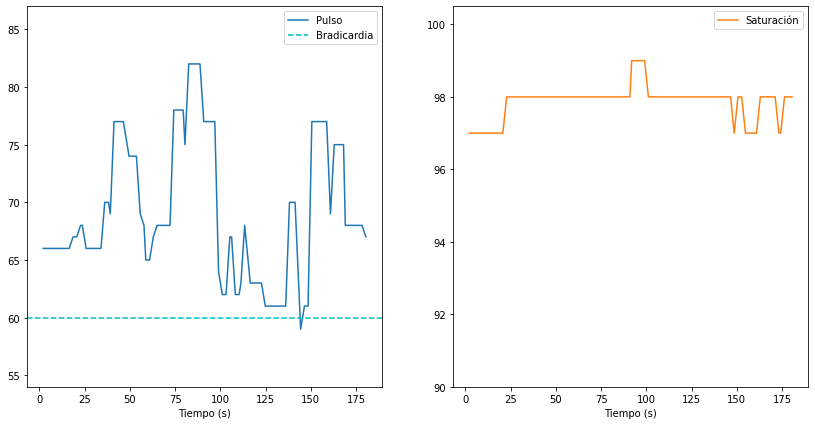

In [15]:
plt.figure(figsize=(14,7))

bpm  = pulse_ox.BPM_series
spo2 = pulse_ox.SpO2_series

plt.subplot(1,2,1)
plt.plot(bpm)
plt.ylim([min(bpm)-5, max(bpm)+5])
plt.xlabel('Tiempo (s)')

new_labels = plot_BPM_levels()
plt.legend(['Pulso'] + new_labels)


plt.subplot(1,2,2)
plt.plot(spo2, 'C1')
plt.ylim([90,100.5])
plt.xlabel('Tiempo (s)')
plt.legend(['Saturación'])

# plot_BPM_levels()
f = plt.gcf()

In [ ]:
pulse_ox.BPM_series

In [155]:
leg = f.get_legend()
f.axes[0].legend(leg)
f

AttributeError: 'Figure' object has no attribute 'get_legend'

In [13]:
def plot_BPM_levels():
    
    fig = plt.gcf()
    legend_labels = list()
    
    # Bradicardia (<60 bpm)
    y_range = fig.axes[0].get_ylim()
    
    if y_range[0] <= 60 <= y_range[1]:
        plt.subplot(1,2,1) # BPM plot
        plt.axhline(60, c='c', linestyle='--')
        legend_labels.append("Bradicardia")
        
    # Taquicardia (>100 bpm)
    y_range = fig.axes[0].get_ylim()
    
    if y_range[0] <= 100 <= y_range[1]:
        plt.subplot(1,2,1) # BPM plot
        plt.axhline(100, c='r', linestyle='--')
        legend_labels.append("Taquicardia")
        
    return legend_labels

In [43]:
def plot_BPM(bpm, spo2):
    plt.figure(figsize=(14,7))

    plt.subplot(1,2,1)
    plt.plot(bpm)
    plt.ylim([min(bpm)-5, max(bpm)+5])
    plt.xlabel('Tiempo (s)')
    plt.legend(['Pulso'])

    plt.subplot(1,2,2)
    plt.plot(spo2, 'C1')
    plt.ylim([90,100.5])
    plt.xlabel('Tiempo (s)')
    plt.legend(['Saturación'])

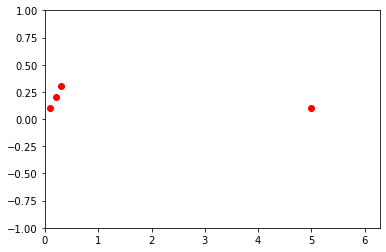

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [0.1,0.2], [0.1,0.2]
ln, = plt.plot([0.1,0.2,0.3,5], [0.1,0.2,.3,.1], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()

In [88]:
ani.

True

In [ ]:
try:
    if pulse_ox_connection and pulse_ox_connection.connected:
        print("Fetch connection")
        if DeviceInfoService in pulse_ox_connection:
            dis = pulse_ox_connection[DeviceInfoService]
            try:
                manufacturer = dis.manufacturer
            except AttributeError:
                manufacturer = "(Manufacturer Not specified)"
                
            try:
                model_number = dis.model_number
            except AttributeError:
                model_number = "(Model number not specified)"
                
            print("Device:", manufacturer, model_number)
            
        else:
            print("No device information")
        pulse_ox_service = pulse_ox_connection[BerryMedPulseOximeterService]
        
        while pulse_ox_connection.connected:
            print(pulse_ox_service.values)
            
except connection_error:
    try:
        pulse_ox_connection.disconnect()
    except connection_error:
        pass
    pulse_ox_connection = None

In [86]:
dir(pulse_ox_connection)
pulse_ox_connection.connected

False

--------------

### PyBluez

In [2]:
import bluetooth
devices = bluetooth.discover_devices(duration=10)
devices

[]

In [3]:
address = '64:B5:C6:41:59:E0'
address = 'AC:C1:EE:00:DA:3F'

In [4]:
addr = ""

In [5]:
joycon_right = '74:F9:CA:85:08:F3'
joycon_left = '04:03:D6:66:92:60'

In [6]:
# address = devices[2]; print(address)

In [8]:
# JC_Right_SV = bluetooth.find_service(address=joycon_right)
# JC_Right_SV[1]

In [9]:
# JC_Right_SV[1]

In [10]:
sock = bluetooth.BluetoothSocket( bluetooth.L2CAP )

ValueError: invalid protocol

In [ ]:
services = bluetooth.find_service()
print(len(services), "servicios encontrados.")

In [ ]:
service_devices = dict()

for elem in services:
    clear_output()
    
    name = elem['name']
    port = elem['port']
    host = elem['host']
    
    print("Nombre:", name)
    print("Puerto:", port)
    print("Direc.:", host)
    print('\n',elem)
    
    if host in service_devices.keys():
        service_devices[host].append(name)
    else:
        service_devices[host] = list()
    
    input()

In [ ]:
for key in devices:
    print("Host:", key)
    print(devices[key])
    print('\n')

In [ ]:
address_services = bluetooth.find_service(address= address)
raw = add_services[0]['rawrecord']

In [ ]:
host = 'AC:C1:EE:00:DA:3F'
name = b'Advanced Audio\x00'
port = 25

In [ ]:
address_services

In [ ]:
host ='AC:C1:EE:00:DA:3F'
name = b'Android Network User\x00'
port = 15

In [ ]:
import socket
socket.

In [ ]:
socket = bluetooth.BluetoothSocket( bluetooth.L2CAP )
socket.bind((host, port))

In [ ]:
socket.AF_

In [ ]:
import socket

channel = 4

s = socket.socket(socket.AF_BLUETOOTH, socket.SOCK_STREAM, socket.BTPROTO_RFCOMM)
s.connect((host,port))
s_sock = server_sock.accept()
print ("Accepted connection from "+address)

data = s_sock.recv(1024)
print ("received [%s]" % data)

s.listen(1)

In [ ]:
if not bluetooth.is_valid_address(address):
    print("Dirección", address, "no válida.")
    
sock = bluetooth.BluetoothSocket( bluetooth.RFCOMM )
sock.bind((address, 1))
sock.listen(1)

In [ ]:
# bluetooth.

### Bleak

In [22]:
from bleak import BleakScanner

async def run():
    devices = await BleakScanner.discover()
    for d in services:
        print(d)

loop = asyncio.get_event_loop()
loop.run_until_complete(run())

RuntimeError: This event loop is already running

In [ ]:
from bleak import BleakClient
async with BleakClient(address) as client:
    res = client.read_gatt_char()